In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyiast as iast
import numpy as np
import ternary as tern
import math
import numdifftools as ndt

In [130]:
mof = "HKUST-1"
xtal_density = {"HKUST-1": 879} # kg/m^3

In [128]:
gases = ["CH4", 
         "N2", 
         "CO2", 
#          "C2H6"
        ]

mol_wts = {"N2" : 28., "CH4" : 16., "CO2" : 44.009, "C2H6" : 30.07}

In [129]:
isotherm_data = dict(
    zip(gases, 
        [pd.read_csv(gas + "_" + mof + ".csv", comment='#') for gas in gases]
       )
)

unit conversions

In [131]:
# cm3 STP  *  L STP      *   mol        * 1000mmol
#  g      1000 cm3 STP    22.4 L STP       1 mol
isotherm_data["CH4"]["N(mmol/g)"] = isotherm_data["CH4"]["cm3/g"] / 22.4

if "N2" in isotherm_data:
    isotherm_data["N2"]["p(bar)"] = isotherm_data["N2"]["p(MPa)"] * 10

if "C2H6" in isotherm_data:
    isotherm_data["C2H6"]["p(bar)"] = isotherm_data["C2H6"]["P(mmHg)"] / 750.062
    # cm3 STP  *  L STP      *   mol      * 1000mmol *    m3 MOF    *   kg      * (100^3) cm3 MOF
    # cm3 MOF  1000 cm3 STP   22.4 L STP     1 mol      ρ_MOF kg      1000 g         m3 MOF
    isotherm_data["C2H6"]["N(mmol/g)"] = isotherm_data["C2H6"]["N(cm3STP_cm3)"] * 100 ** 3 / 1000 / 22.4 / xtal_density[mof]

fit isotherm models

In [68]:
isotherms = {}
for gas in gases:
    isotherms[gas] = iast.ModelIsotherm(isotherm_data[gas], loading_key="N(mmol/g)", pressure_key="p(bar)", model="Langmuir")

In [97]:
henrys = dict(zip(gases, [isotherms[gas].params['M'] * isotherms[gas].params['K']  for gas in gases]))
henrys

{'CH4': 1.0013155424617308, 'N2': 0.2362919014851018, 'CO2': 6.439124221964564}

In [104]:
gas_to_color = dict(zip(gases, ["C{0}".format(i) for i in range(len(gases))]))

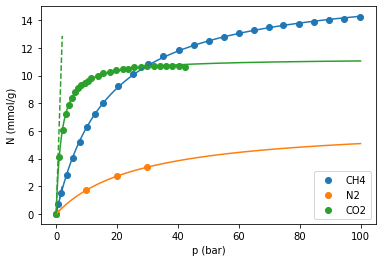

In [106]:
plt.figure()

p_range = np.linspace(0, 100, 500)

for gas in gases:
    plt.scatter(isotherm_data[gas]["p(bar)"], isotherm_data[gas]["N(mmol/g)"], 
                marker='o', label=gas, color=gas_to_color[gas])
    plt.plot(p_range, isotherms[gas].loading(p_range))
    p_small = np.linspace(0.0, 2.0)
    plt.plot(p_small, henrys[gas] * p_small, linestyle="--", color=gas_to_color[gas])
# plt.xlim(0, 5)
plt.xlabel("p (bar)")
plt.ylabel("N (mmol/g)")
plt.legend()

In [70]:
def adsorbed_mass(mol_fxns):
    q = iast.iast(mol_fxns, [isotherms[gas] for gas in gases], warningoff=True)
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    return np.sum([q[j] * mol_wts[gases[j]] for j in range(len(gases))]) / 1000

In [78]:
delta = 0.005
x = np.arange(0.01, 0.3, delta)
y = np.arange(0.01, 0.3, delta)
X, Y = np.meshgrid(x, y)
Z = np.zeros(np.shape(X))
for i in range(np.shape(X)[0]):
    for j in range(np.shape(Y)[1]):
        mol_fxn = [1 - x[i] - y[j], x[i], y[j]]
        Z[j, i] = adsorbed_mass(mol_fxn)

In [124]:
op_pt = np.array([0.7, 0.15, 0.15])
m_op = adsorbed_mass(op_pt)
print("m at op point: ", m_op)
J = ndt.Jacobian(adsorbed_mass, method="forward")
j_op = J(op_pt)[0][1:]
v1, v2 = np.linalg.svd([j_op])[2]

m at op point:  0.04806012190779715


/home/cokes/anaconda3/lib/python3.8/site-packages/pyiast-1.4.3-py3.8.egg/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


In [121]:
np.linalg.svd([j_op])

(array([[-1.]]),
 array([0.22451848]),
 array([[-0.01933453, -0.99981307],
        [-0.99981307,  0.01933453]]))

In [122]:
# v1, v2 = np.linalg.svd([[henrys[gas] for gas in gases][1:]])[2]

(0.01, 0.295, 0.01, 0.295)

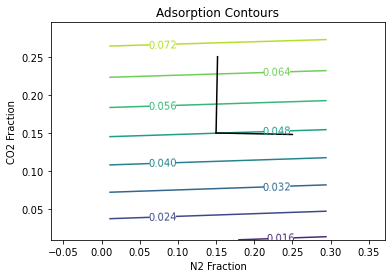

In [125]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Adsorption Contours')
ax.set_xlabel(gases[1] + " Fraction")
ax.set_ylabel(gases[2] + " Fraction")
plt.plot([op_pt[1], op_pt[1] - v1[0]/10], [op_pt[2], op_pt[2] - v1[1]/10], color='k')
plt.plot([op_pt[1], op_pt[1] - v2[0]/10], [op_pt[2], op_pt[2] - v2[1]/10], color='k')
plt.axis("equal")

In [16]:
def V(x, y, z):
    x, y, z = x[0][0], y[0][0], z[0][0]
    print(x, y, z)
    if x + y + z <= 1:
        return adsorbed_mass([1 - x - y - z, x, y, z])
    else:
        return NaN

In [ ]:
X, Y, Z = np.mgrid[0.001:0.003:0.999, 0.001:0.003:0.999, 0.001:0.003:0.999]
X, Y, Z

In [ ]:
V(X, Y, Z)

In [ ]:
from mayavi import mlab
mlab.contour3d(X, Y, Z, V)

In [ ]:
figure, tax = tern.figure(scale=100)
tax.heatmapf(adsorbed_mass, boundary=False, style="hexagonal")
tax.gridlines(multiple=10)
tax.ticks(multiple=10)
tax.set_title("Heatmap")
tax.left_axis_label(gases[2])
tax.right_axis_label(gases[1])
tax.bottom_axis_label(gases[0])

In [ ]:
# near-pure CH4
adsorbed_mass([0.99,0.005,0.005])

In [ ]:
# near-pure N2
adsorbed_mass([0.005, 0.99, 0.005])

In [ ]:
# near-pure CO2
adsorbed_mass([0.005,0.005,0.99])

In [ ]:
figure, tax = tern.figure(scale=100)
tax.scatter([[1,0,0]])
tax.ticks(multiple=25)

In [ ]:
plt.figure()
plt.plot(x_ch4, m_ads)
plt.ylim(ymin=0)
plt.xlabel("Fraction of CH4")
plt.ylabel("Total Adsorbed Mass (g/g)")
plt.title("Calibration Curve")